In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import tensorflow as tf


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


In [2]:
import cv2

Загружаем картинки для сегментации (имена почти одинаковые: изображение.png - это сам кадр и изображение (1).png - это разметка)

Вот так загружаем с локального диска

In [ ]:
from google.colab import files

uploaded = files.upload()



In [ ]:
!ls

'modelC (1).png'   modelC.png   modelU.png   sample_data


Открываем архив (это зависит от архива)

In [ ]:
!pip install rarfile

In [ ]:
import rarfile

rf = rarfile.RarFile("small_segment.rar")
for f in rf.infolist():
    print(f.filename, f.file_size)
    if f.filename == "README":
        print(rf.read(f))
rf.extractall()

labels/00_000200.png 19401
labels/00_000400.png 14502
labels/00_000600.png 19818
labels/00_000800.png 13554
labels/00_001000.png 14496
labels/00_001200.png 17371
labels/00_001400.png 12431
labels/00_001600.png 16390
labels/00_001800.png 16646
labels/00_002000.png 14844
labels/00_002200.png 14011
labels/00_002400.png 16921
labels/00_002600.png 15822
labels/00_002800.png 13681
labels/00_003000.png 13980
labels/00_003200.png 15122
labels/00_003400.png 13978
images/00_000200.png 791603
images/00_000400.png 816531
images/00_000600.png 862976
images/00_000800.png 836923
images/00_001000.png 829576
images/00_001200.png 822001
images/00_001400.png 858981
images/00_001600.png 797385
images/00_001800.png 850589
images/00_002000.png 818966
images/00_002200.png 641760
images/00_002400.png 714888
images/00_002600.png 774166
images/00_002800.png 890605
images/00_003000.png 837876
images/00_003200.png 755342
images/00_003400.png 695524
labels/ 0
images/ 0


In [ ]:
!ls

images	labels	sample_data  small_segment.rar


А вот так загрузим картинки с Гугл Диска (делаем только один вариант загрузки)

In [3]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


Прочитаем списки наших файлов (проверить идентичность, если имена одинаковые или собрать порядок чтения любым доступным способом)

Задаю маршрут для чтения

In [4]:
PAHT_label = '/gdrive/My Drive/нейросети Ноутбуки для вебинаров Корлякова/урок 6/labels/'
PAHT_image = '/gdrive/My Drive/нейросети Ноутбуки для вебинаров Корлякова/урок 6/images/'
  

In [5]:
import os, fnmatch
imag = os.listdir(PAHT_label)
imag_label = os.listdir(PAHT_image)

In [6]:
imag,imag_label

(['00_001200.png',
  '00_001000.png',
  '00_002800.png',
  '00_002200.png',
  '00_001600.png',
  '00_002400.png',
  '00_001800.png',
  '00_002600.png',
  '00_003400.png',
  '00_000600.png',
  '00_000800.png',
  '00_000400.png',
  '00_003200.png',
  '00_003000.png',
  '00_000200.png',
  '00_002000.png',
  '00_001400.png'],
 ['00_001600.png',
  '00_001400.png',
  '00_002000.png',
  '00_003200.png',
  '00_001000.png',
  '00_002600.png',
  '00_001800.png',
  '00_000200.png',
  '00_000600.png',
  '00_001200.png',
  '00_003000.png',
  '00_000400.png',
  '00_003400.png',
  '00_000800.png',
  '00_002800.png',
  '00_002400.png',
  '00_002200.png'])

#Загружаем и уменьшаем картинки

можно обойтись исходным рахзмером или взять другой

ВАЖНО - размер по обеим сторонам должен делиться на 2 несколько раз (сколько будет сжатий кадра)

In [7]:
images = []
segments = []
image_size = (200,600)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))


Посмотрели на входные кадры

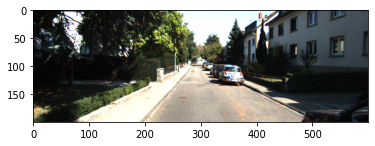

In [8]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

Посмотрим на цели

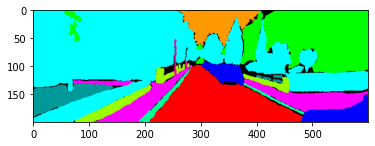

In [9]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

#Создаём обучающую выборку

Собираем входные примеры:

In [10]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [11]:
print(xTrain_Test.shape)

(17, 200, 600, 3)


Порстроим цвета , воспринимаемого диапазона для сегментированной картинки - это результат разметки, которую принесет разметчик

Color Coding:

Name	(r,g,b)	    7-Class mapping

Car	  ( 0, 0,255)	Object

Road	(255, 0, 0)	Road

Mark	(255,255, 0)	Road

Building	( 0,255, 0)	Building

Sidewalk	(255, 0,255)	Road

Tree/Bush	( 0,255,255)	Tree/Bush

Pole	(255, 0,153)	Sign/Pole

Sign	(153, 0,255)	Sign/Pole

Person	( 0,153,255)	Object

Wall	(153,255, 0)	Building

Sky	(255,153, 0)	Sky

Curb	( 0,255,153)	Road

Grass/Dirt	( 0,153,153)	Grass/Dirt

Void	( 0, 0, 0)	Void



Делаем конвертер в one-hot_encoding для выходных примеров

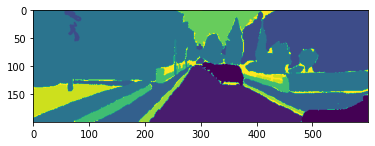

In [12]:
def Color2index(y):
  arr_col=[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  


In [13]:
np.sum(cat_yi[100:,:100,1] )

0.0

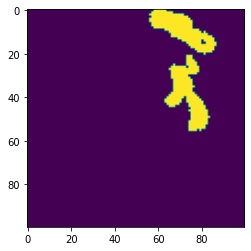

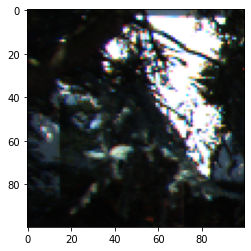

In [14]:
plt.imshow(cat_yi[:100,:100,3])
plt.show()
plt.imshow(xTrain_Test[0,:100,:100,:]/255)
plt.show()

In [15]:
cat_yi.shape

(200, 600, 14)

Сегментированную картинку в  One hot encoding (разметка на 14 классов)**

In [16]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [17]:
print(yTrain_Test.shape)

(17, 200, 600, 14)


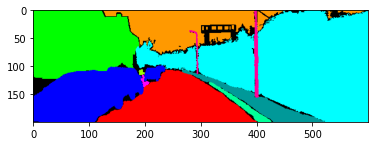

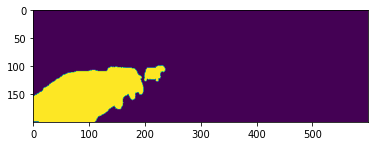

In [18]:
n = 10
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()

Делим на тест и трейн по числу N

In [19]:
N = 15
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [20]:
yTest.shape

(2, 200, 600, 14)

In [21]:
print(xTrain.shape)
print(yTrain.shape)

(15, 200, 600, 3)
(15, 200, 600, 14)


#Создаём и обучаем U-net

In [22]:
from tensorflow.keras.utils import plot_model

**Unet**

In [23]:
def Unet(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 600, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 600, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 200, 600, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

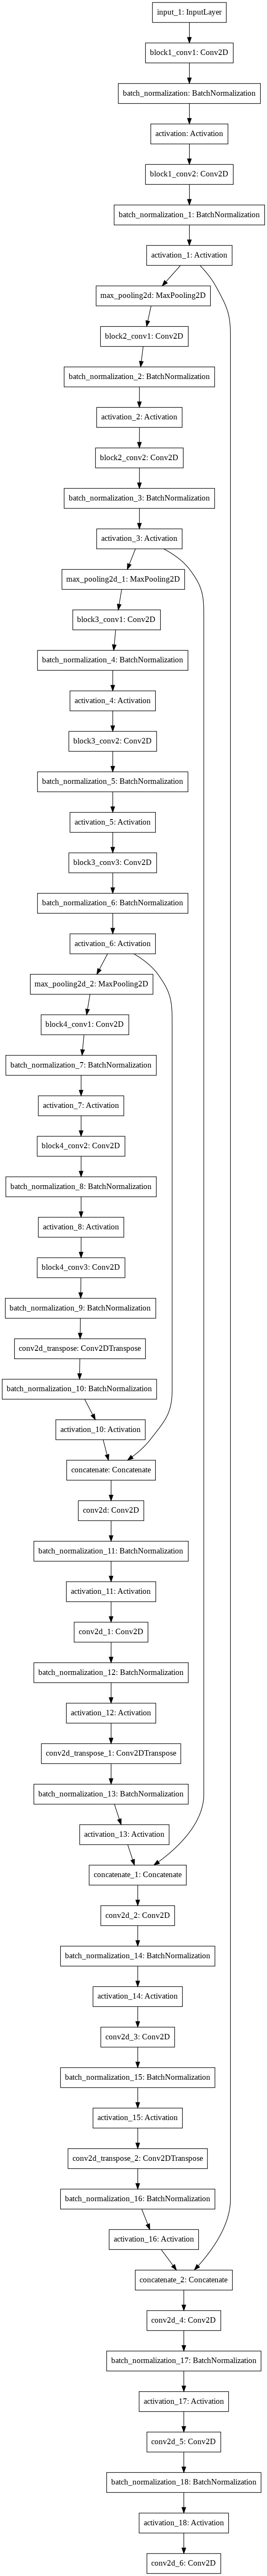

In [24]:
modelC = Unet(14, (200, 600, 3))

plot_model(modelC, to_file='modelC.png')

In [25]:

history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
15/15 [==============================] - 38s 197ms/step - loss: 2.0822 - dice_coef: 0.2288 - val_loss: 3375.3655 - val_dice_coef: 0.2680
Epoch 2/10
15/15 [==============================] - 2s 167ms/step - loss: 1.6065 - dice_coef: 0.3211 - val_loss: 6223.8730 - val_dice_coef: 0.2692
Epoch 3/10
15/15 [==============================] - 2s 166ms/step - loss: 1.4783 - dice_coef: 0.3316 - val_loss: 1005.3153 - val_dice_coef: 0.2697
Epoch 4/10
15/15 [==============================] - 2s 162ms/step - loss: 1.3955 - dice_coef: 0.3775 - val_loss: 262.8634 - val_dice_coef: 0.2696
Epoch 5/10
15/15 [==============================] - 2s 163ms/step - loss: 1.3350 - dice_coef: 0.3850 - val_loss: 42.3134 - val_dice_coef: 0.2824
Epoch 6/10
15/15 [==============================] - 2s 163ms/step - loss: 1.2617 - dice_coef: 0.4217 - val_loss: 10.7241 - val_dice_coef: 0.3229
Epoch 7/10
15/15 [==============================] - 2s 167ms/step - loss: 1.1955 - dice_coef: 0.4503 - val_loss: 12.2778 -

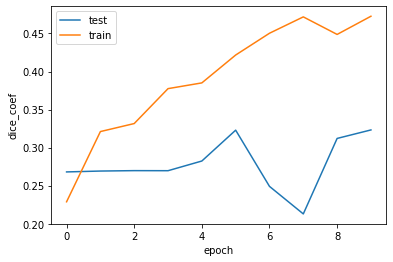

In [26]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [27]:
history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
15/15 [==============================] - 3s 173ms/step - loss: 1.0139 - dice_coef: 0.5154 - val_loss: 4.1494 - val_dice_coef: 0.4078
Epoch 2/10
15/15 [==============================] - 2s 167ms/step - loss: 0.9576 - dice_coef: 0.5413 - val_loss: 2.0999 - val_dice_coef: 0.4463
Epoch 3/10
15/15 [==============================] - 2s 167ms/step - loss: 0.9472 - dice_coef: 0.5428 - val_loss: 1.7876 - val_dice_coef: 0.4737
Epoch 4/10
15/15 [==============================] - 2s 165ms/step - loss: 0.9168 - dice_coef: 0.5572 - val_loss: 2.3821 - val_dice_coef: 0.4527
Epoch 5/10
15/15 [==============================] - 2s 168ms/step - loss: 0.8681 - dice_coef: 0.5890 - val_loss: 1.5470 - val_dice_coef: 0.5188
Epoch 6/10
15/15 [==============================] - 2s 166ms/step - loss: 0.8716 - dice_coef: 0.5837 - val_loss: 2.1314 - val_dice_coef: 0.4730
Epoch 7/10
15/15 [==============================] - 3s 170ms/step - loss: 0.8850 - dice_coef: 0.5785 - val_loss: 1.7731 - val_dice_coef:

In [28]:
pred = modelC.predict(xTest)
print(pred.shape)

(2, 200, 600, 14)


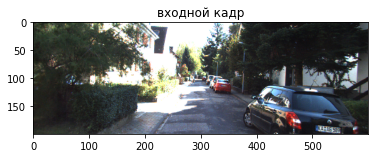

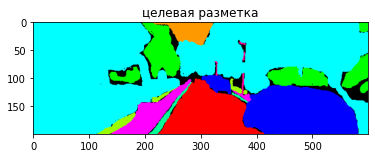

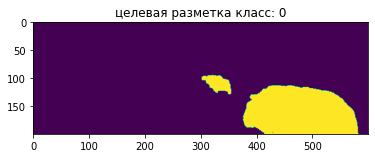

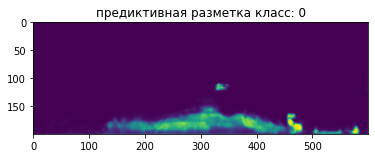

In [29]:
n = 1
class_ =0
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

**Претренированная  Unet**

In [30]:
 pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

58892288/58889256 [==============================] - 1s 0us/step


In [31]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 150, 128)      0     

In [32]:
def bloc_transpose(x,block_out, numb_filter = [256,128]):
  x = concatenate([x, block_out])
  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 
  x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [34]:
def unet_pre_train(num_classes = 13, input_shape= (200, 600, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    x = pre_trained_model.layers[13].output # конец сверток
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output # первое уменьшение размера
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x, block_4_out, numb_filter = [256,128])
    

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_3_out, numb_filter = [128,64])
    

    # UP 3
  

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_2_out, numb_filter = [64,32])


    # UP 4
   
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

KerasTensor(type_spec=TensorSpec(shape=(None, 25, 75, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 50, 150, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 300, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 600, 64) 1792        input_3[0][0]         

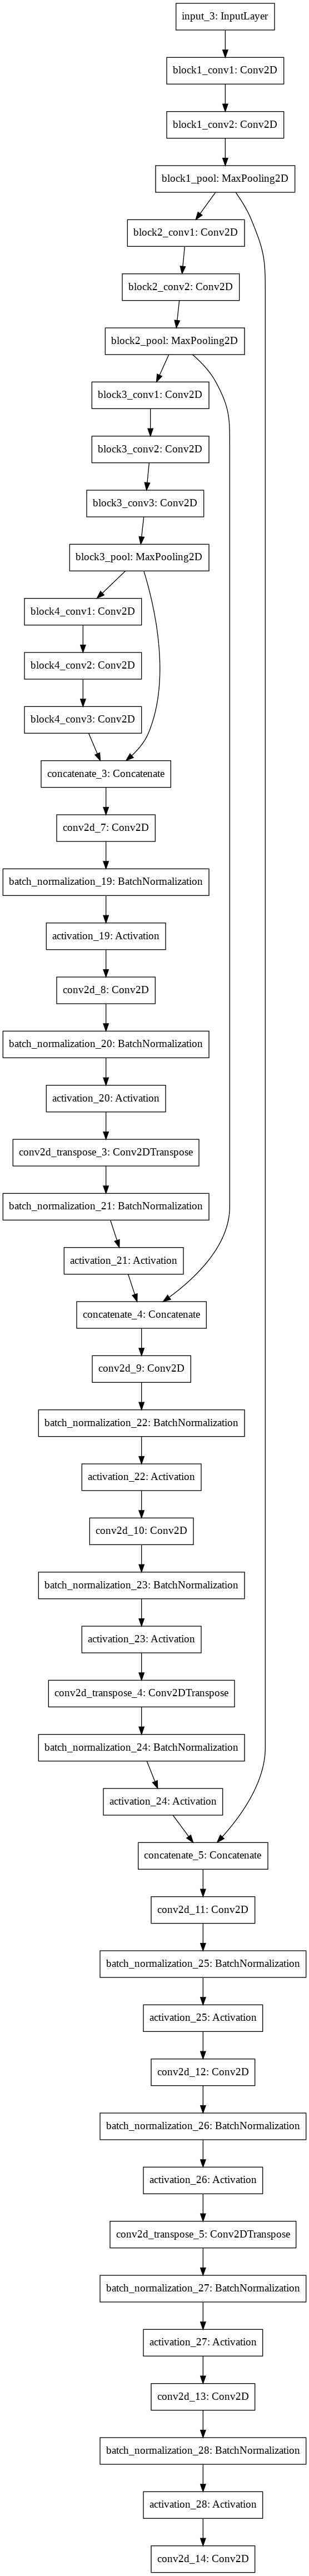

In [35]:
modelU = unet_pre_train(num_classes = 14, input_shape= (200, 600, 3))

plot_model(modelU, to_file='modelU.png')

In [36]:
from IPython.display import clear_output

In [37]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    Ipred = self.model(xTest[:1])

    k = Ipred.shape[3]
    if k>4:
      k = 4
    print('Predict')
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(Ipred[0,:,:,i])
    
    plt.show() 
    print('True') 
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(yTest[0,:,:,i])
    
    plt.show()

    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/40
5/5 [==============================] - 6s 306ms/step - loss: 2.4550 - dice_coef: 0.1337 - val_loss: 2.2369 - val_dice_coef: 0.1679
Predict


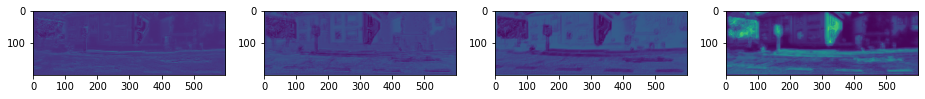

True


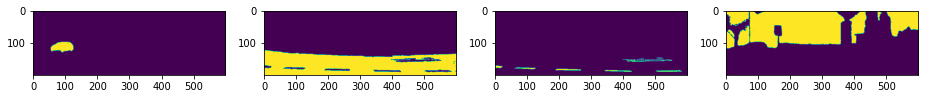


Sample Prediction after epoch 1

Epoch 2/40
5/5 [==============================] - 1s 289ms/step - loss: 1.7489 - dice_coef: 0.2749 - val_loss: 2.1592 - val_dice_coef: 0.1525
Predict


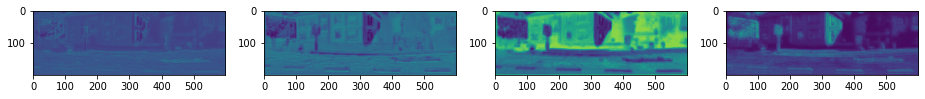

True


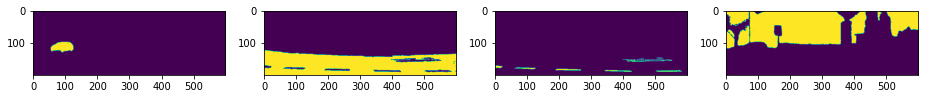


Sample Prediction after epoch 2

Epoch 3/40
5/5 [==============================] - 1s 290ms/step - loss: 1.5725 - dice_coef: 0.3429 - val_loss: 2.1797 - val_dice_coef: 0.1560
Predict


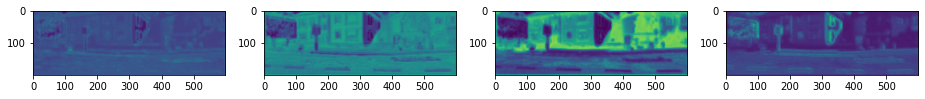

True


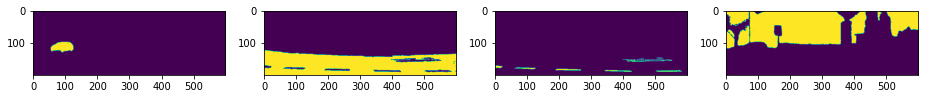


Sample Prediction after epoch 3

Epoch 4/40
5/5 [==============================] - 1s 226ms/step - loss: 1.4788 - dice_coef: 0.3621 - val_loss: 2.0993 - val_dice_coef: 0.1813
Predict


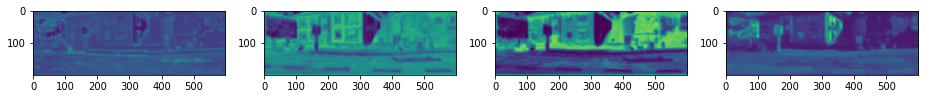

True


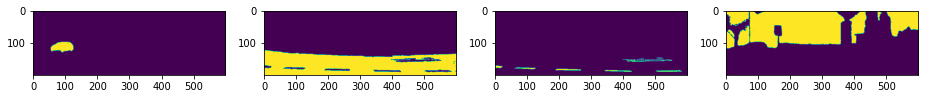


Sample Prediction after epoch 4

Epoch 5/40
5/5 [==============================] - 1s 290ms/step - loss: 1.3901 - dice_coef: 0.3846 - val_loss: 2.1405 - val_dice_coef: 0.1659
Predict


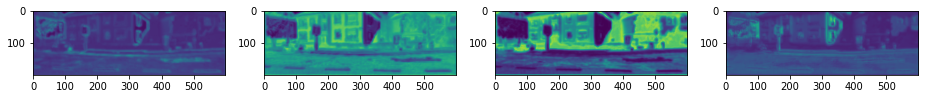

True


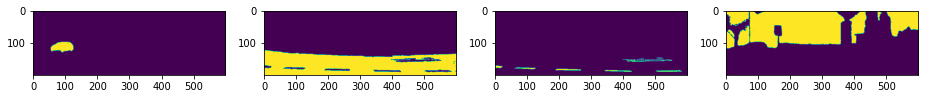


Sample Prediction after epoch 5

Epoch 6/40
5/5 [==============================] - 1s 229ms/step - loss: 1.3272 - dice_coef: 0.3886 - val_loss: 2.1096 - val_dice_coef: 0.1702
Predict


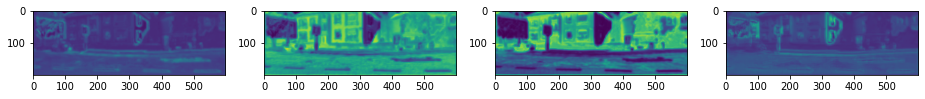

True


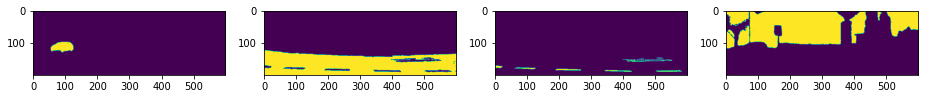


Sample Prediction after epoch 6

Epoch 7/40
5/5 [==============================] - 1s 228ms/step - loss: 1.2668 - dice_coef: 0.4117 - val_loss: 2.1019 - val_dice_coef: 0.1644
Predict


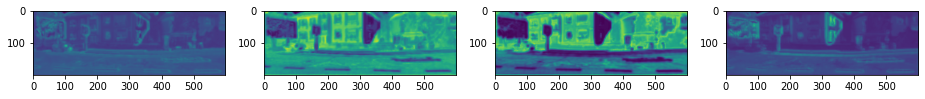

True


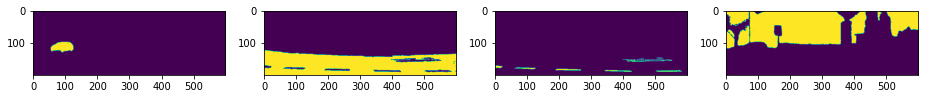


Sample Prediction after epoch 7

Epoch 8/40
5/5 [==============================] - 1s 291ms/step - loss: 1.2482 - dice_coef: 0.4292 - val_loss: 2.0556 - val_dice_coef: 0.1667
Predict


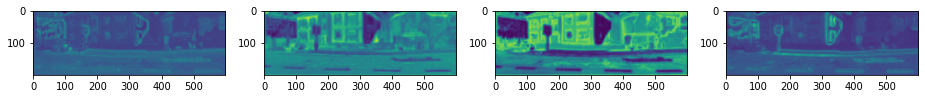

True


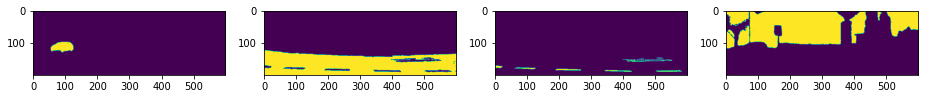


Sample Prediction after epoch 8

Epoch 9/40
5/5 [==============================] - 1s 290ms/step - loss: 1.1343 - dice_coef: 0.4585 - val_loss: 2.0633 - val_dice_coef: 0.1655
Predict


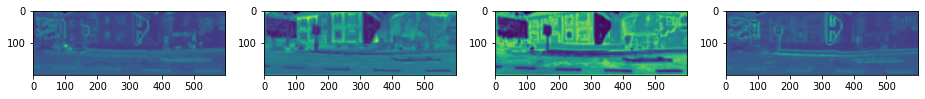

True


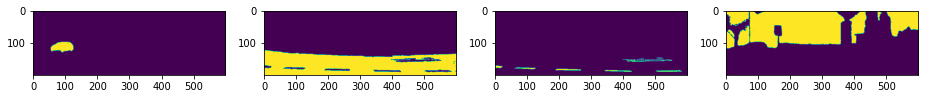


Sample Prediction after epoch 9

Epoch 10/40
5/5 [==============================] - 1s 293ms/step - loss: 1.0975 - dice_coef: 0.4837 - val_loss: 2.0230 - val_dice_coef: 0.1702
Predict


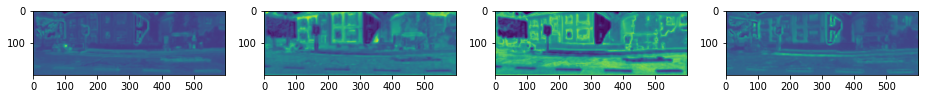

True


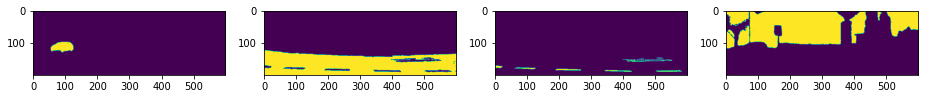


Sample Prediction after epoch 10

Epoch 11/40
5/5 [==============================] - 1s 231ms/step - loss: 1.0895 - dice_coef: 0.4922 - val_loss: 2.0127 - val_dice_coef: 0.1668
Predict


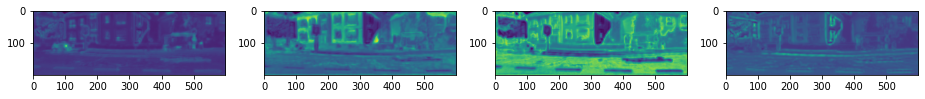

True


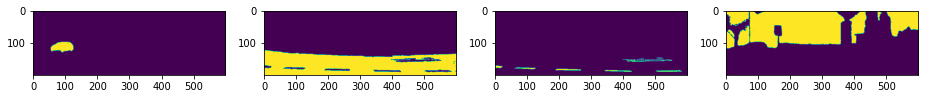


Sample Prediction after epoch 11

Epoch 12/40
5/5 [==============================] - 1s 228ms/step - loss: 1.1135 - dice_coef: 0.4944 - val_loss: 1.9520 - val_dice_coef: 0.1848
Predict


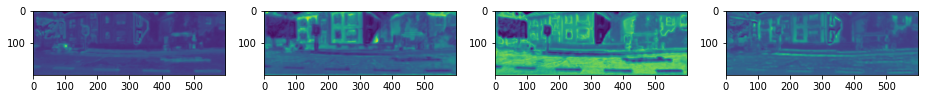

True


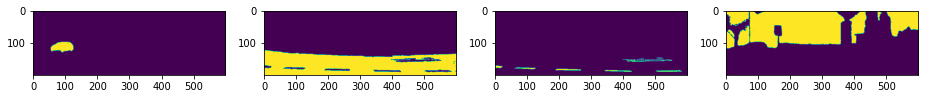


Sample Prediction after epoch 12

Epoch 13/40
5/5 [==============================] - 1s 290ms/step - loss: 1.0650 - dice_coef: 0.5029 - val_loss: 1.9507 - val_dice_coef: 0.1911
Predict


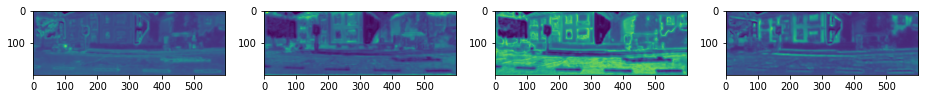

True


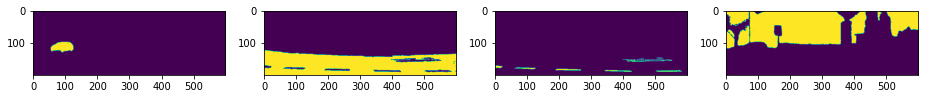


Sample Prediction after epoch 13

Epoch 14/40
5/5 [==============================] - 1s 231ms/step - loss: 1.0300 - dice_coef: 0.5236 - val_loss: 1.8928 - val_dice_coef: 0.1974
Predict


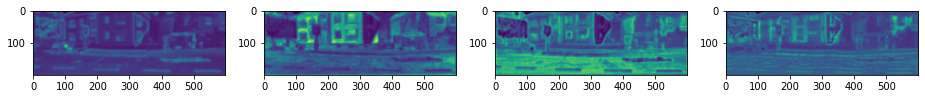

True


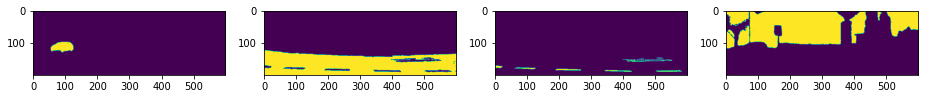


Sample Prediction after epoch 14

Epoch 15/40
5/5 [==============================] - 1s 294ms/step - loss: 1.0443 - dice_coef: 0.5126 - val_loss: 1.7503 - val_dice_coef: 0.2182
Predict


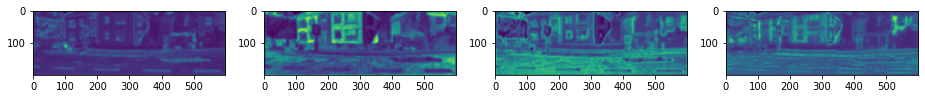

True


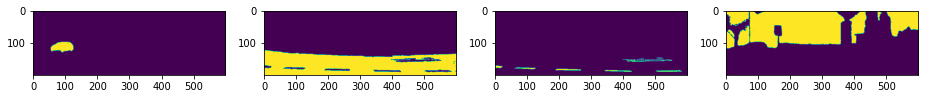


Sample Prediction after epoch 15

Epoch 16/40
5/5 [==============================] - 1s 293ms/step - loss: 0.9790 - dice_coef: 0.5356 - val_loss: 1.6802 - val_dice_coef: 0.2416
Predict


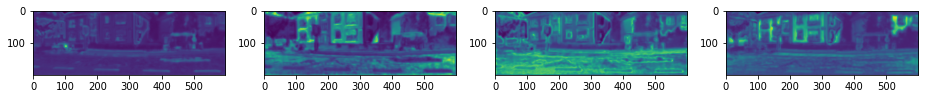

True


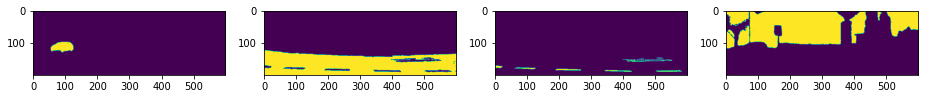


Sample Prediction after epoch 16

Epoch 17/40
5/5 [==============================] - 1s 233ms/step - loss: 0.9579 - dice_coef: 0.5404 - val_loss: 1.6327 - val_dice_coef: 0.2523
Predict


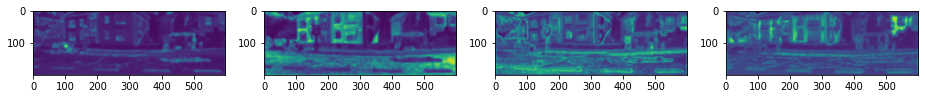

True


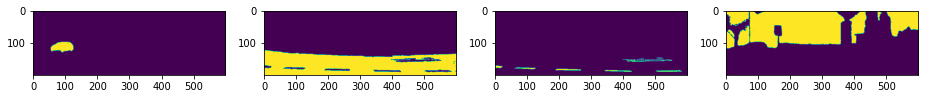


Sample Prediction after epoch 17

Epoch 18/40
5/5 [==============================] - 1s 233ms/step - loss: 0.9930 - dice_coef: 0.5495 - val_loss: 1.4931 - val_dice_coef: 0.2976
Predict


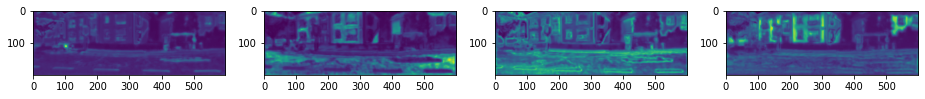

True


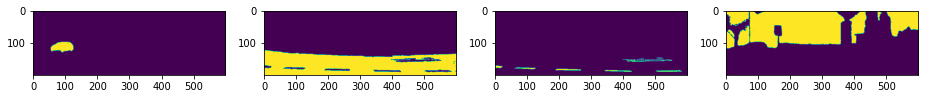


Sample Prediction after epoch 18

Epoch 19/40
5/5 [==============================] - 1s 291ms/step - loss: 0.9630 - dice_coef: 0.5438 - val_loss: 1.5438 - val_dice_coef: 0.2709
Predict


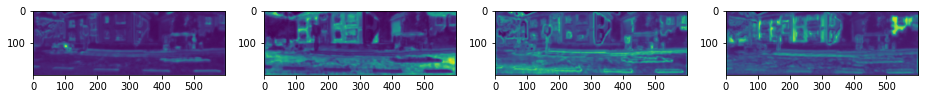

True


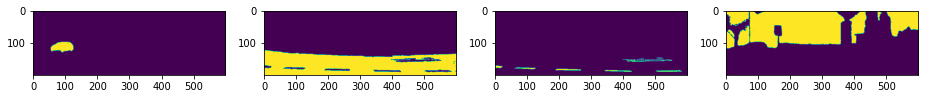


Sample Prediction after epoch 19

Epoch 20/40
5/5 [==============================] - 1s 229ms/step - loss: 0.9175 - dice_coef: 0.5582 - val_loss: 1.5669 - val_dice_coef: 0.2810
Predict


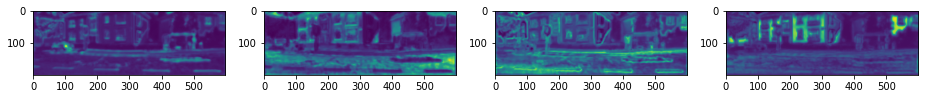

True


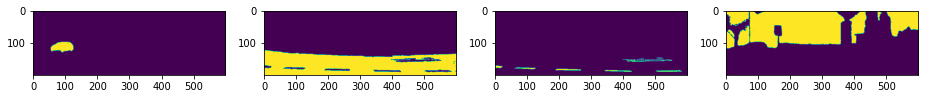


Sample Prediction after epoch 20

Epoch 21/40
5/5 [==============================] - 1s 292ms/step - loss: 0.9181 - dice_coef: 0.5606 - val_loss: 1.4003 - val_dice_coef: 0.3108
Predict


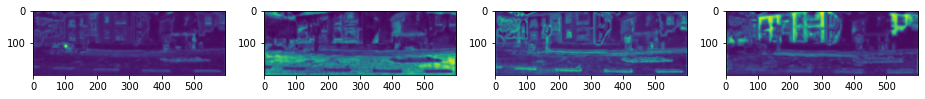

True


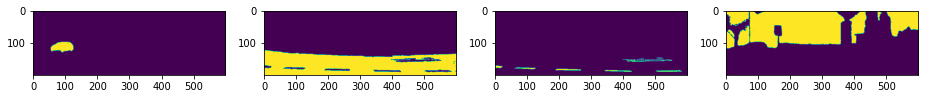


Sample Prediction after epoch 21

Epoch 22/40
5/5 [==============================] - 1s 230ms/step - loss: 0.8862 - dice_coef: 0.5771 - val_loss: 1.3420 - val_dice_coef: 0.3380
Predict


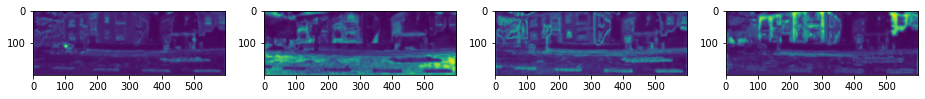

True


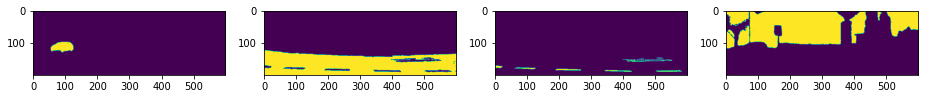


Sample Prediction after epoch 22

Epoch 23/40
5/5 [==============================] - 1s 231ms/step - loss: 0.8366 - dice_coef: 0.5924 - val_loss: 1.2776 - val_dice_coef: 0.3613
Predict


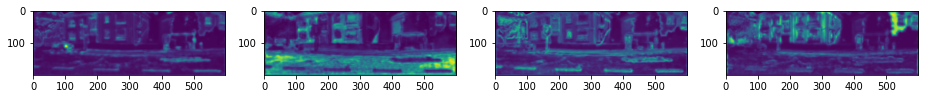

True


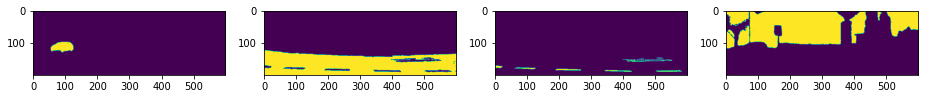


Sample Prediction after epoch 23

Epoch 24/40
5/5 [==============================] - 1s 295ms/step - loss: 0.8548 - dice_coef: 0.5962 - val_loss: 1.3913 - val_dice_coef: 0.3368
Predict


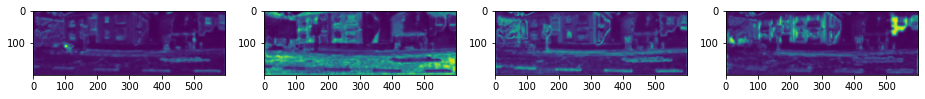

True


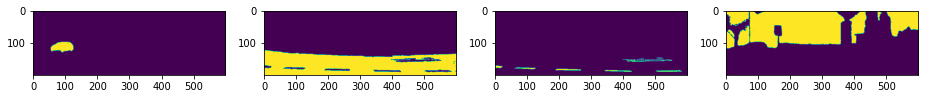


Sample Prediction after epoch 24

Epoch 25/40
5/5 [==============================] - 1s 294ms/step - loss: 0.8486 - dice_coef: 0.5912 - val_loss: 1.2670 - val_dice_coef: 0.3708
Predict


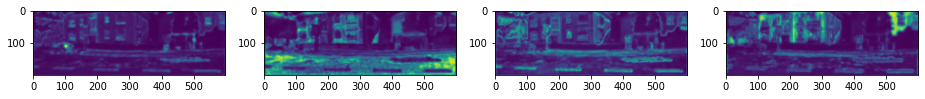

True


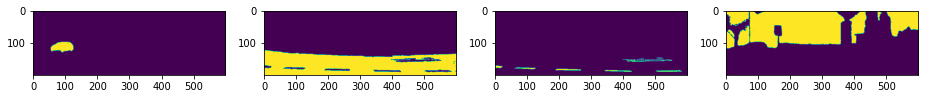


Sample Prediction after epoch 25

Epoch 26/40
5/5 [==============================] - 1s 232ms/step - loss: 0.8166 - dice_coef: 0.6042 - val_loss: 1.1558 - val_dice_coef: 0.4051
Predict


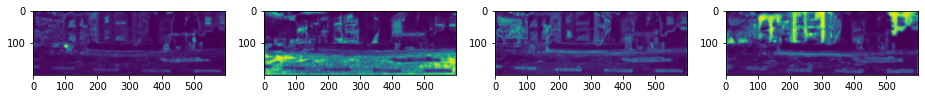

True


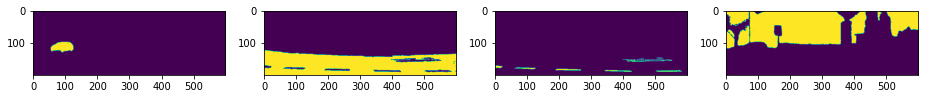


Sample Prediction after epoch 26

Epoch 27/40
5/5 [==============================] - 1s 234ms/step - loss: 0.8376 - dice_coef: 0.5982 - val_loss: 1.1783 - val_dice_coef: 0.4041
Predict


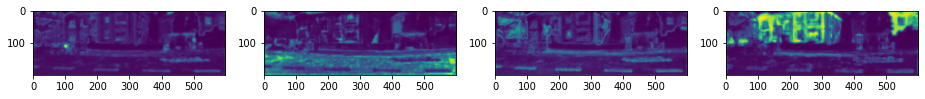

True


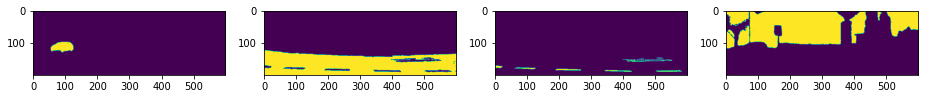


Sample Prediction after epoch 27

Epoch 28/40
5/5 [==============================] - 1s 238ms/step - loss: 0.8777 - dice_coef: 0.5993 - val_loss: 1.2526 - val_dice_coef: 0.3887
Predict


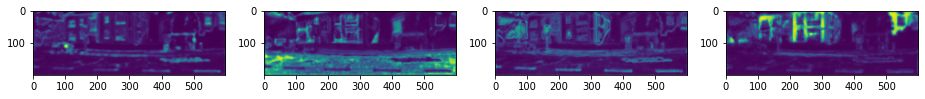

True


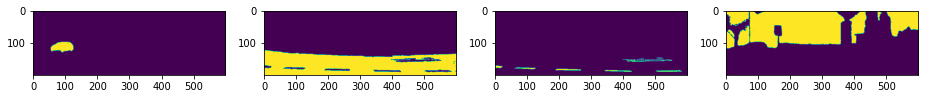


Sample Prediction after epoch 28

Epoch 29/40
5/5 [==============================] - 1s 292ms/step - loss: 0.7679 - dice_coef: 0.6241 - val_loss: 1.1242 - val_dice_coef: 0.4168
Predict


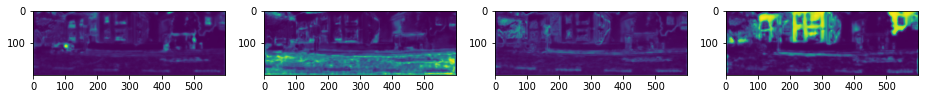

True


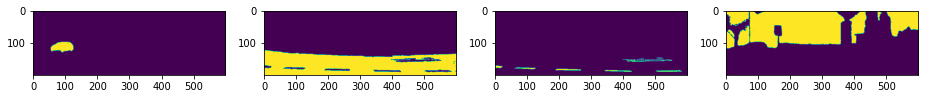


Sample Prediction after epoch 29

Epoch 30/40
5/5 [==============================] - 1s 236ms/step - loss: 0.8391 - dice_coef: 0.5959 - val_loss: 1.2303 - val_dice_coef: 0.3950
Predict


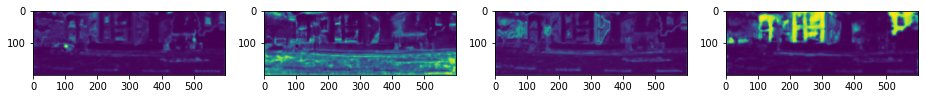

True


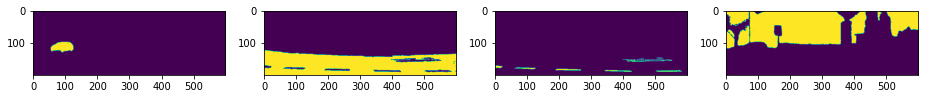


Sample Prediction after epoch 30

Epoch 31/40
5/5 [==============================] - 1s 298ms/step - loss: 0.7630 - dice_coef: 0.6231 - val_loss: 1.0912 - val_dice_coef: 0.4410
Predict


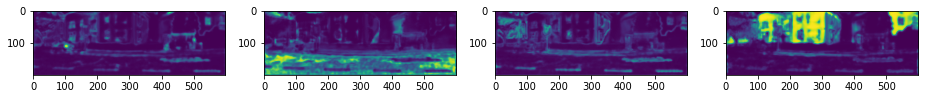

True


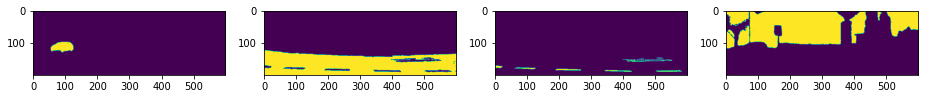


Sample Prediction after epoch 31

Epoch 32/40
5/5 [==============================] - 1s 291ms/step - loss: 0.7553 - dice_coef: 0.6308 - val_loss: 1.2296 - val_dice_coef: 0.4292
Predict


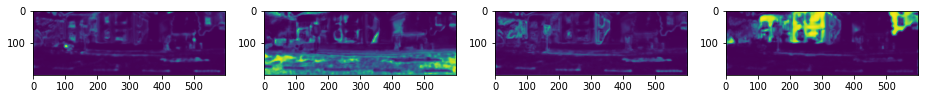

True


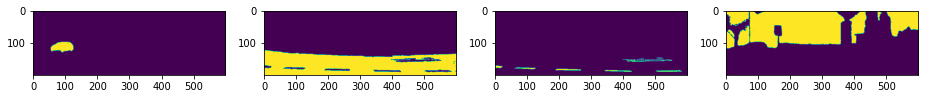


Sample Prediction after epoch 32

Epoch 33/40
5/5 [==============================] - 1s 293ms/step - loss: 0.7665 - dice_coef: 0.6283 - val_loss: 1.1855 - val_dice_coef: 0.4454
Predict


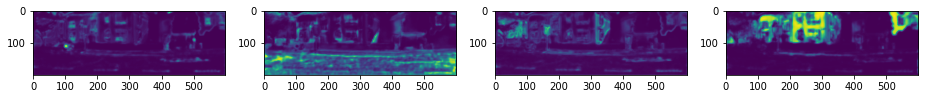

True


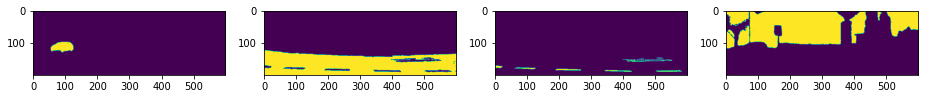


Sample Prediction after epoch 33

Epoch 34/40
5/5 [==============================] - 1s 297ms/step - loss: 0.7443 - dice_coef: 0.6327 - val_loss: 1.0912 - val_dice_coef: 0.4534
Predict


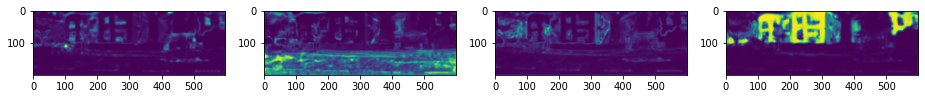

True


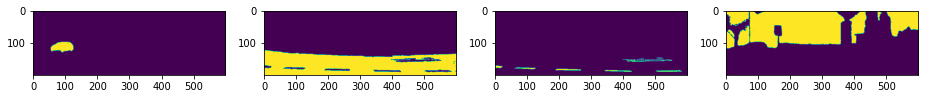


Sample Prediction after epoch 34

Epoch 35/40
5/5 [==============================] - 1s 295ms/step - loss: 0.7362 - dice_coef: 0.6425 - val_loss: 0.9073 - val_dice_coef: 0.5174
Predict


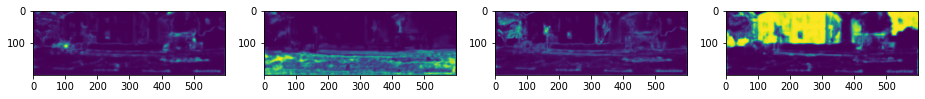

True


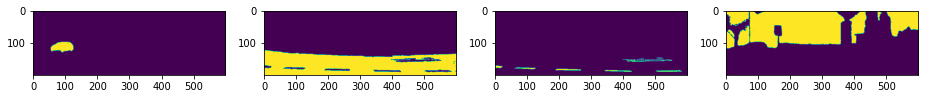


Sample Prediction after epoch 35

Epoch 36/40
5/5 [==============================] - 1s 236ms/step - loss: 0.7181 - dice_coef: 0.6453 - val_loss: 0.9413 - val_dice_coef: 0.5201
Predict


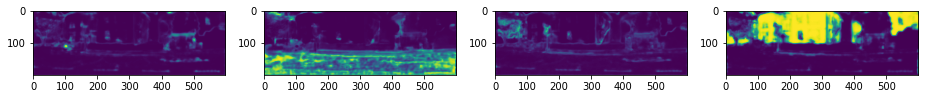

True


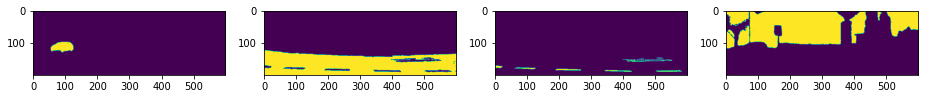


Sample Prediction after epoch 36

Epoch 37/40
5/5 [==============================] - 1s 292ms/step - loss: 0.6951 - dice_coef: 0.6574 - val_loss: 1.1201 - val_dice_coef: 0.4838
Predict


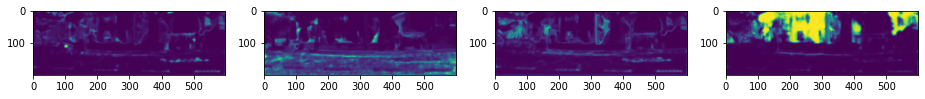

True


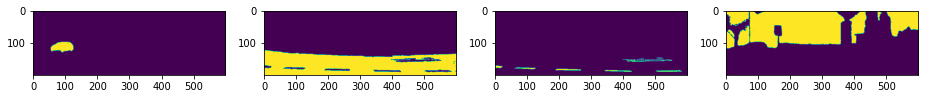


Sample Prediction after epoch 37

Epoch 38/40
5/5 [==============================] - 1s 291ms/step - loss: 0.7073 - dice_coef: 0.6583 - val_loss: 1.1391 - val_dice_coef: 0.4899
Predict


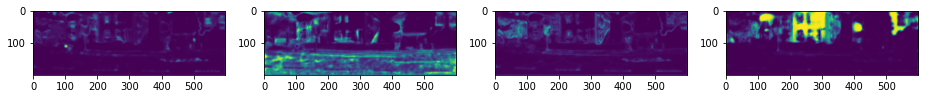

True


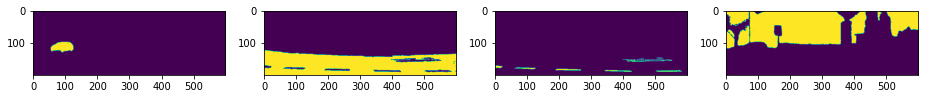


Sample Prediction after epoch 38

Epoch 39/40
5/5 [==============================] - 1s 234ms/step - loss: 0.7634 - dice_coef: 0.6421 - val_loss: 0.7835 - val_dice_coef: 0.6063
Predict


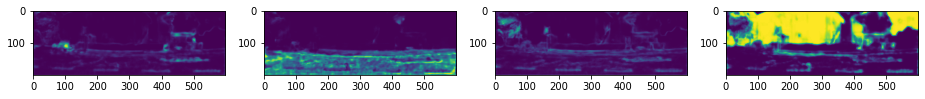

True


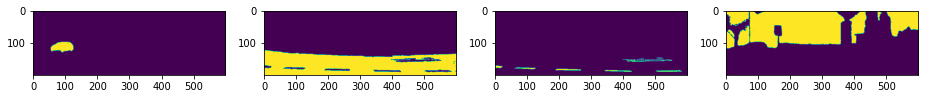


Sample Prediction after epoch 39

Epoch 40/40
5/5 [==============================] - 1s 232ms/step - loss: 0.6955 - dice_coef: 0.6602 - val_loss: 0.8836 - val_dice_coef: 0.5682
Predict


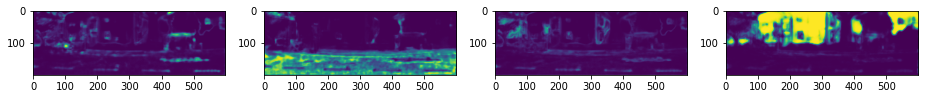

True


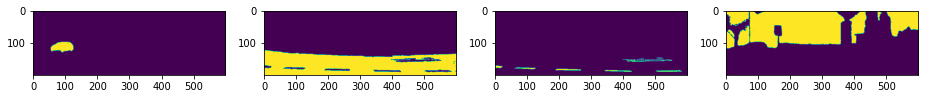


Sample Prediction after epoch 40



In [38]:
history = modelU.fit(xTrain, yTrain, epochs=40, batch_size=3, validation_data=(xTrain, yTrain), callbacks = [tf.keras.callbacks.EarlyStopping( patience=5 ), DisplayCallback()])

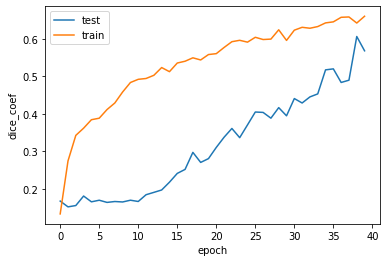

In [39]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

#Распознаём обучающую выборку

In [40]:
predu = modelU.predict(xTest)
print(predu.shape)


(2, 200, 600, 14)


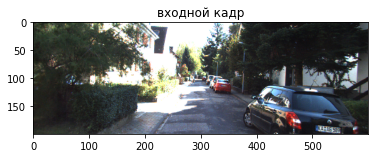

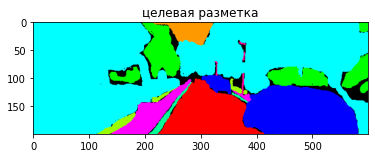

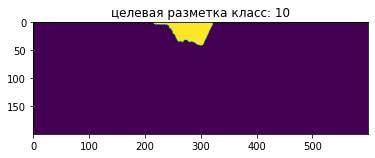

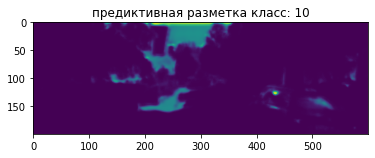

In [43]:
n = 1
class_ = 10
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()


Что еще делаем:

- аугментацию
- ищем новые примеры
- проверяем разметку
- меняем модель